In [1]:
# Enable inline plotting (for Jupyter Notebook only)
# Note: Use this only if running in Jupyter Notebook
%matplotlib inline

# Suppress warnings (for cleaner report)
import warnings
warnings.filterwarnings("ignore")

# Core libraries
import numpy as np
import pandas as pd
import plotly.express as px

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and forecasting
from sklearn.linear_model import LinearRegression
from prophet import Prophet  # Advanced forecasting

# Set random seed for reproducibility
np.random.seed(37)


## **Data Gathering**

### **1. Trade Volume and Goods Dataset**


In [2]:
# Define ports and goods categories
ports = ['Alexandria', 'Damietta', 'Port Said', 'Tripoli', 'Benghazi', 'Misurata']
goods_categories = ['Raw Materials', 'Manufactured Goods', 'Perishables', 'Machinery', 'Others']

# Generate synthetic trade data (2003–2023)
years = list(range(2003, 2024))
data = []

for year in years:
    for port in ports:
        for good in goods_categories:
            # Base trade volume
            volume = np.random.randint(500, 10000)
            
            # Adjust for major events
            if 2010 <= year <= 2012:  # Arab Spring
                volume *= 0.7
            elif 2020 <= year <= 2021:  # COVID-19 Pandemic
                volume *= 0.5
            elif year == 2022:  # Post-pandemic recovery
                volume *= 0.8
            
            data.append([port, good, volume, year])

trade_volume_df = pd.DataFrame(data, columns=['Port', 'Good Category', 'Trade Volume (Metric Tons)', 'Trade Year'])


### **2. Shipping Fuel Cost Dataset**

In [3]:
# Synthetic fuel cost data
fuel_cost_data = {
    'Year': years,
    'Fuel Cost (USD per Metric Ton)': np.random.uniform(300, 700, len(years))
}
fuel_cost_df = pd.DataFrame(fuel_cost_data)


### **3. Port Information Dataset**

In [4]:
# Port information dataset
port_info_data = {
    "Port": ports,
    "Country": ['Egypt', 'Egypt', 'Egypt', 'Libya', 'Libya', 'Libya'],
    "Annual Capacity (Metric Tons)": [200000, 180000, 220000, 150000, 160000, 140000],
    "Infrastructure Quality (1-10)": [8, 7, 9, 6, 5, 5],
    "Proximity to Trade Hubs (1-10)": [9, 8, 9, 6, 7, 6],
    "Political Stability (1-10)": [7, 7, 8, 4, 5, 4],
    "Customs Efficiency (1-10)": [8, 7, 9, 5, 6, 5]
}
port_info_df = pd.DataFrame(port_info_data)


### **4. Vessel Type Dataset**

In [5]:
# Vessel types data
vessel_types_data = {
    "Vessel Type": ['Container Ship', 'Bulk Carrier', 'Tanker', 'General Cargo', 'Reefer'],
    "Capacity (Metric Tons)": [20000, 30000, 25000, 15000, 12000],
    "Operational Cost per Trip (USD)": [50000, 60000, 70000, 40000, 45000],
    "Suitable for Goods": [
        'Manufactured Goods, Machinery',
        'Raw Materials, Others',
        'Perishables, Liquid Cargo',
        'General Cargo, Machinery',
        'Perishables'
    ]
}
vessel_types_df = pd.DataFrame(vessel_types_data)


### **5. Saving Raw Datasets**

In [6]:
# Save raw datasets
#trade_volume_df.to_csv('./data/raw/trade_volume.csv', index=False)
#fuel_cost_df.to_csv('./data/raw/fuel_cost.csv', index=False)
#port_info_df.to_csv('./data/raw/port_info.csv', index=False)
#vessel_types_df.to_csv('./data/raw/vessel_types.csv', index=False)


## **Data Wrangling**

### **1. Feature Engineering**

#### **Calculate Cost per Ton for Each Vessel Type**

In [7]:
# Calculate cost per ton for each vessel type
vessel_types_df["Cost per Ton (USD)"] = vessel_types_df["Operational Cost per Trip (USD)"] / vessel_types_df["Capacity (Metric Tons)"]



#### **Calculate Dynamic Risk Scores for Ports**

In [8]:
# Calculate dynamic risk scores for ports
weights = {
    'Infrastructure Quality (1-10)': 0.3,
    'Proximity to Trade Hubs (1-10)': 0.2,
    'Political Stability (1-10)': 0.3,
    'Customs Efficiency (1-10)': 0.2
}

for column, weight in weights.items():
    port_info_df[column + ' Norm'] = port_info_df[column] / 10

port_info_df['Risk Score'] = 1 - (
    port_info_df['Infrastructure Quality (1-10) Norm'] * weights['Infrastructure Quality (1-10)'] +
    port_info_df['Proximity to Trade Hubs (1-10) Norm'] * weights['Proximity to Trade Hubs (1-10)'] +
    port_info_df['Political Stability (1-10) Norm'] * weights['Political Stability (1-10)'] +
    port_info_df['Customs Efficiency (1-10) Norm'] * weights['Customs Efficiency (1-10)']
)

# Merge trade data with port info
trade_with_ports = trade_volume_df.merge(port_info_df, on="Port", how="left")

# Merge with fuel costs
trade_with_ports = trade_with_ports.merge(fuel_cost_df, left_on='Trade Year', right_on='Year', how='left')


#### **Calculate Operational Costs**

In [9]:
# Calculate operational costs
trade_with_ports['Operational Cost'] = trade_with_ports['Trade Volume (Metric Tons)'] * trade_with_ports['Fuel Cost (USD per Metric Ton)'] / 1000


### **2. Saving Processed Datasets**

In [10]:
# Save processed datasets
#trade_with_ports.to_csv('./data/processed/trade_with_ports.csv', index=False)
#port_info_df.to_csv('./data/processed/port_info_processed.csv', index=False)
#vessel_types_df.to_csv('./data/processed/vessel_types_processed.csv', index=False)


## **Exploratory Data Analysis (EDA)**

### **1. Total Trade Volume by Year and Goods Category**

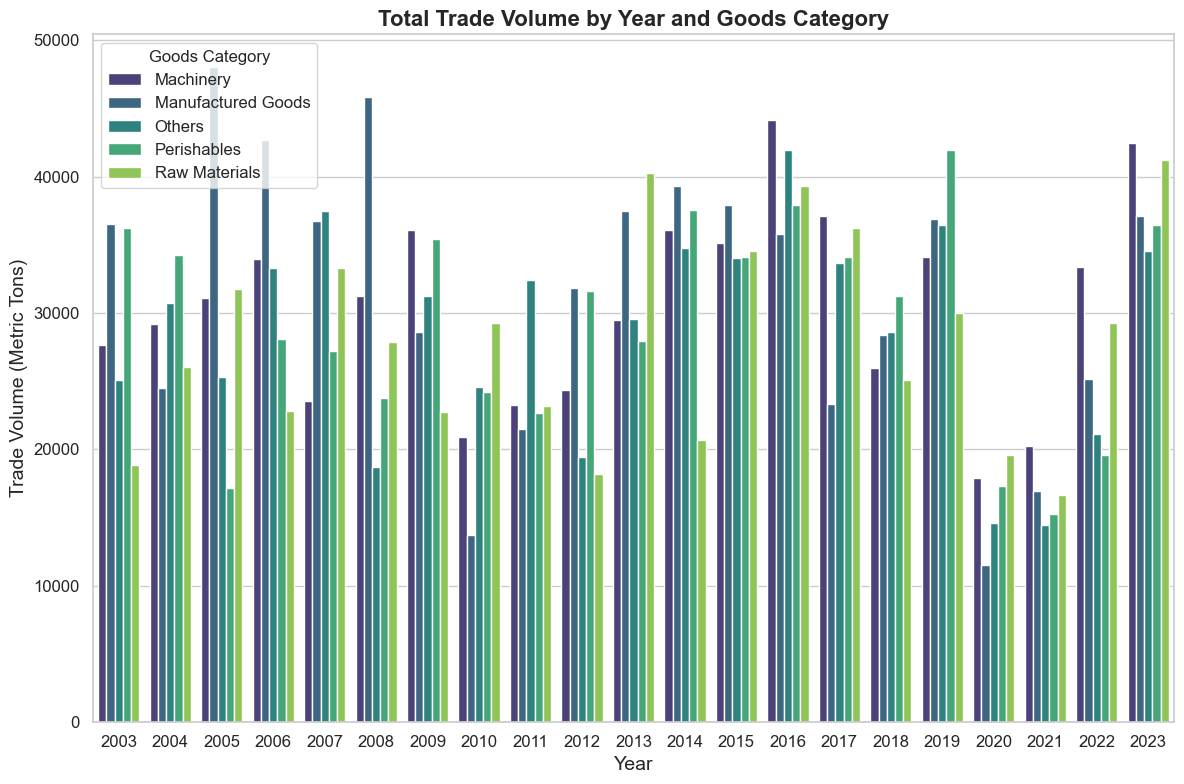

In [11]:
# Set visualization aesthetics
sns.set_theme(style="whitegrid")

# Total Trade Volume by Year and Goods Category
plt.figure(figsize=(12, 8))
trade_summary = trade_with_ports.groupby(["Trade Year", "Good Category"]).agg({
    "Trade Volume (Metric Tons)": "sum"
}).reset_index()

sns.barplot(
    data=trade_summary,
    x="Trade Year",
    y="Trade Volume (Metric Tons)",
    hue="Good Category",
    palette="viridis"
)
plt.title("Total Trade Volume by Year and Goods Category", fontsize=16, weight="bold")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Trade Volume (Metric Tons)", fontsize=14)
plt.legend(title="Goods Category", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show();


### **2. Annual Port Capacities**

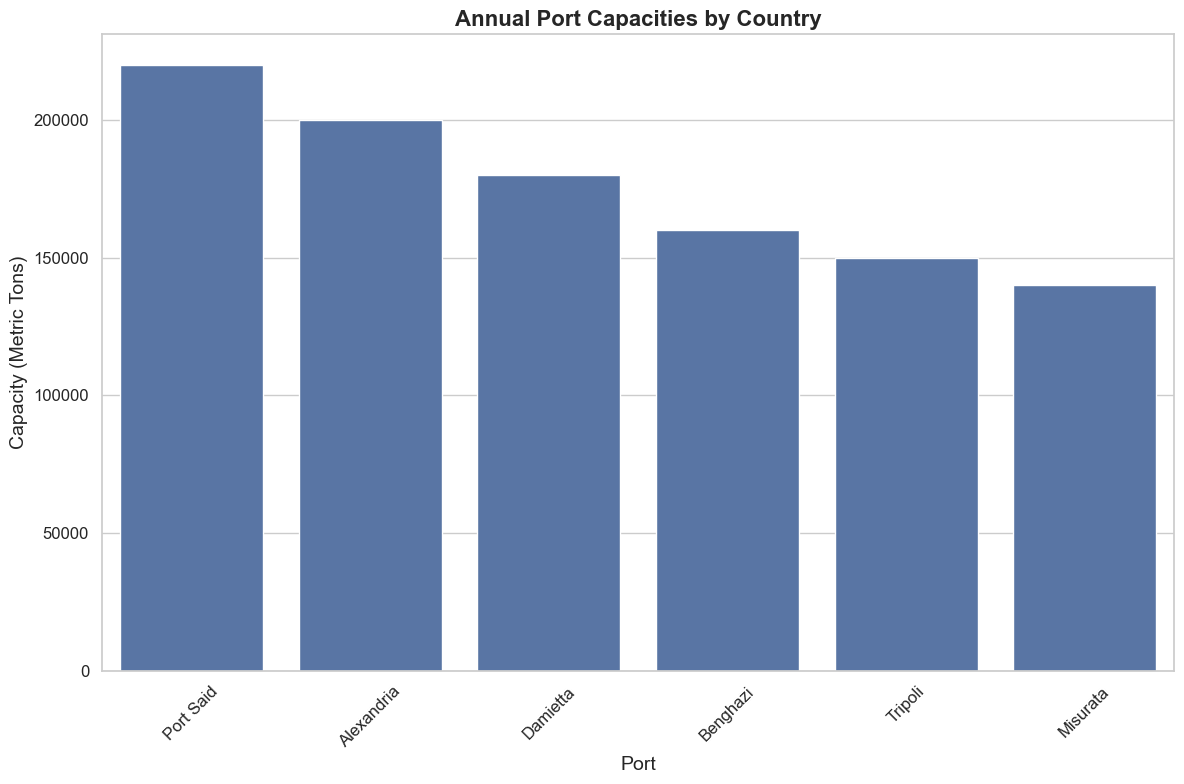

In [12]:
# Annual Port Capacities
plt.figure(figsize=(12, 8))

# Sorting ports by annual capacity
sorted_ports = port_info_df.sort_values("Annual Capacity (Metric Tons)", ascending=False)

# Plotting the bar chart
sns.barplot(
    data=sorted_ports,
    x="Port",
    y="Annual Capacity (Metric Tons)",
    color="#4C72B0"
)
plt.title("Annual Port Capacities by Country", fontsize=16, weight="bold")
plt.xlabel("Port", fontsize=14)
plt.ylabel("Capacity (Metric Tons)", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show();


### **3. Cost Efficiency of Vessel Types**

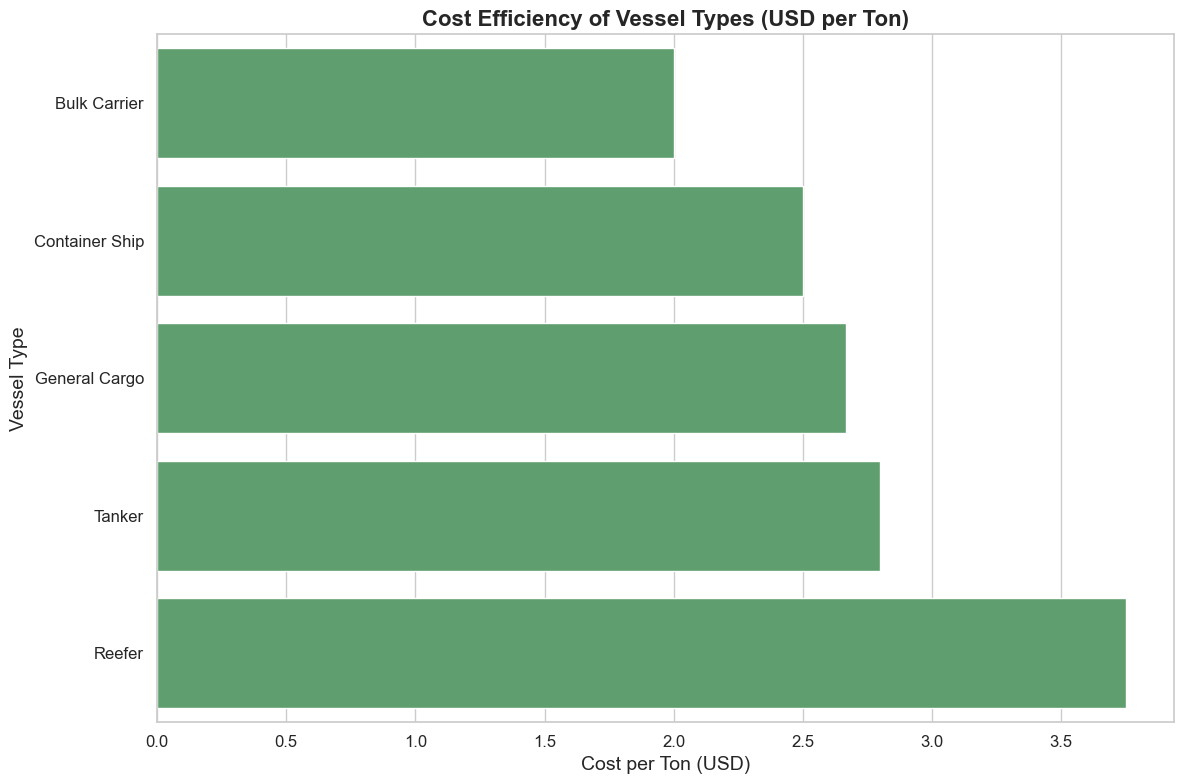

In [13]:
# Cost Efficiency of Vessel Types
plt.figure(figsize=(12, 8))

# Sorting vessel types by cost per ton
sorted_vessels = vessel_types_df.sort_values("Cost per Ton (USD)", ascending=True)

# Plotting the bar chart
sns.barplot(
    data=sorted_vessels,
    x="Cost per Ton (USD)",
    y="Vessel Type",
    color="#55A868"
)
plt.title("Cost Efficiency of Vessel Types (USD per Ton)", fontsize=16, weight="bold")
plt.xlabel("Cost per Ton (USD)", fontsize=14)
plt.ylabel("Vessel Type", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


### **4. Trade Volume Distribution by Port**

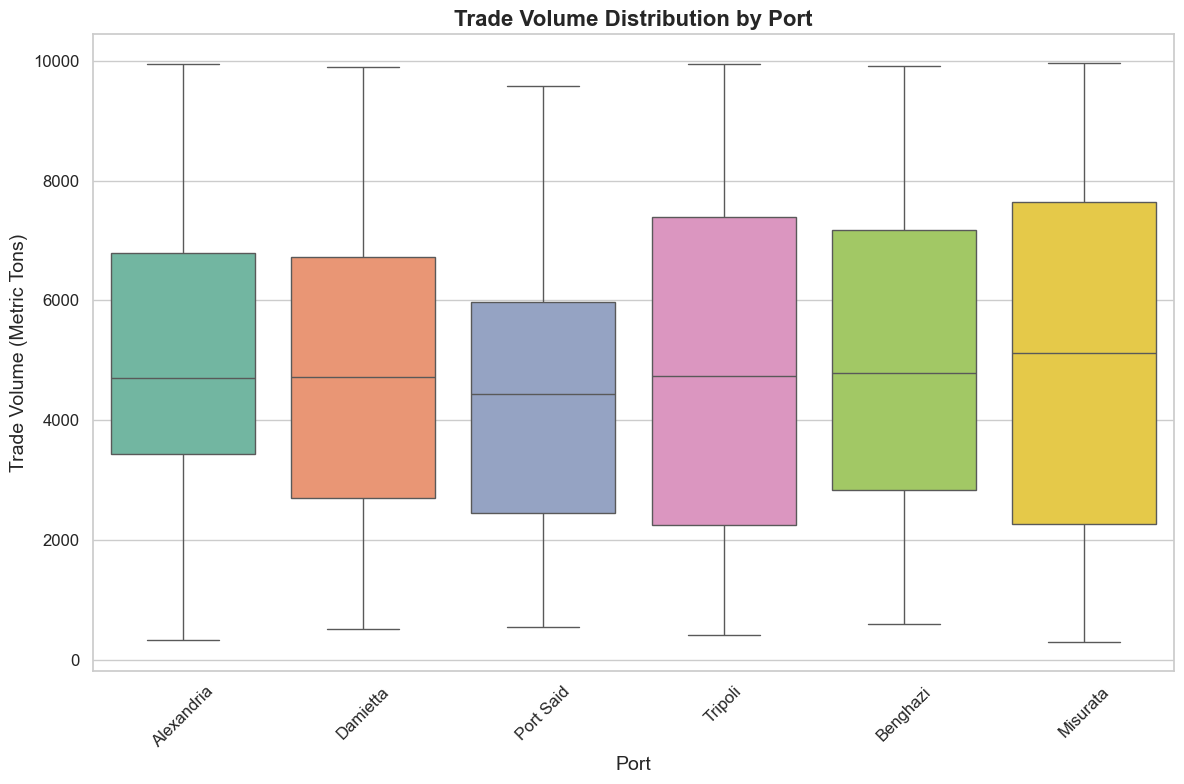

In [14]:
# Trade Volume Distribution by Port
plt.figure(figsize=(12, 8))

# Boxplot for trade volume distribution
sns.boxplot(
    data=trade_with_ports,
    x="Port",
    y="Trade Volume (Metric Tons)",
    palette="Set2"
)
plt.title("Trade Volume Distribution by Port", fontsize=16, weight="bold")
plt.xlabel("Port", fontsize=14)
plt.ylabel("Trade Volume (Metric Tons)", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show();


### **5. Correlation Heatmap for Numerical Variables in Ports**

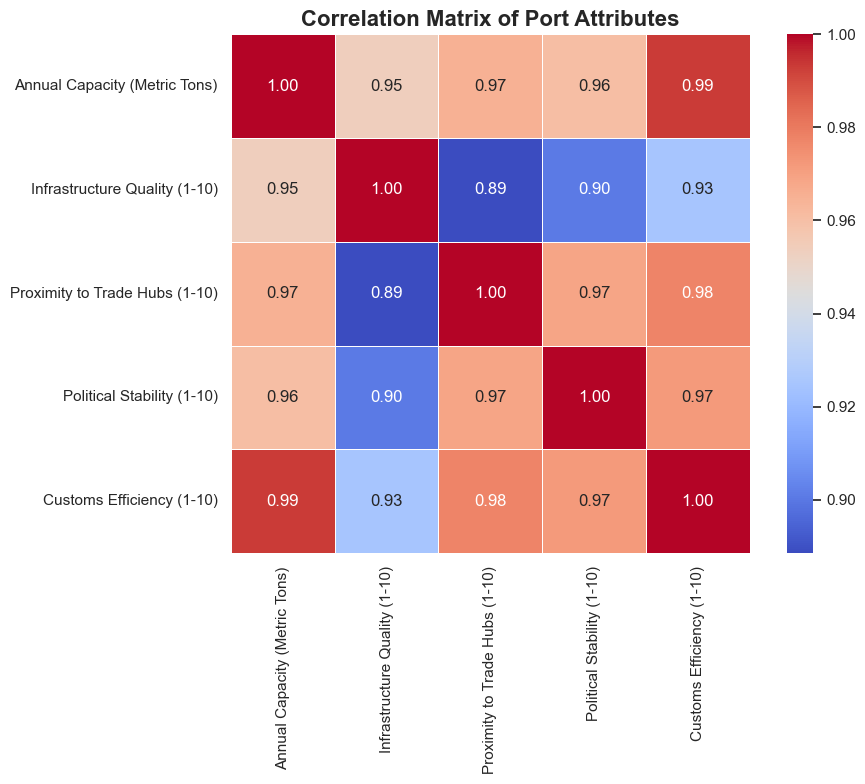

In [15]:
# Correlation Heatmap for Numerical Variables in Ports
plt.figure(figsize=(10, 8))

# Selecting numerical columns for correlation
numerical_columns = [
    "Annual Capacity (Metric Tons)", 
    "Infrastructure Quality (1-10)", 
    "Proximity to Trade Hubs (1-10)", 
    "Political Stability (1-10)", 
    "Customs Efficiency (1-10)"
]

# Calculating the correlation matrix
corr = port_info_df[numerical_columns].corr()

# Plotting the heatmap
sns.heatmap(
    corr, 
    annot=True, 
    cmap="coolwarm", 
    fmt=".2f", 
    square=True, 
    linewidths=0.5
)
plt.title("Correlation Matrix of Port Attributes", fontsize=16, weight="bold")
plt.tight_layout()
plt.show()


### **6. Yearly Trade Volume for Top Ports**

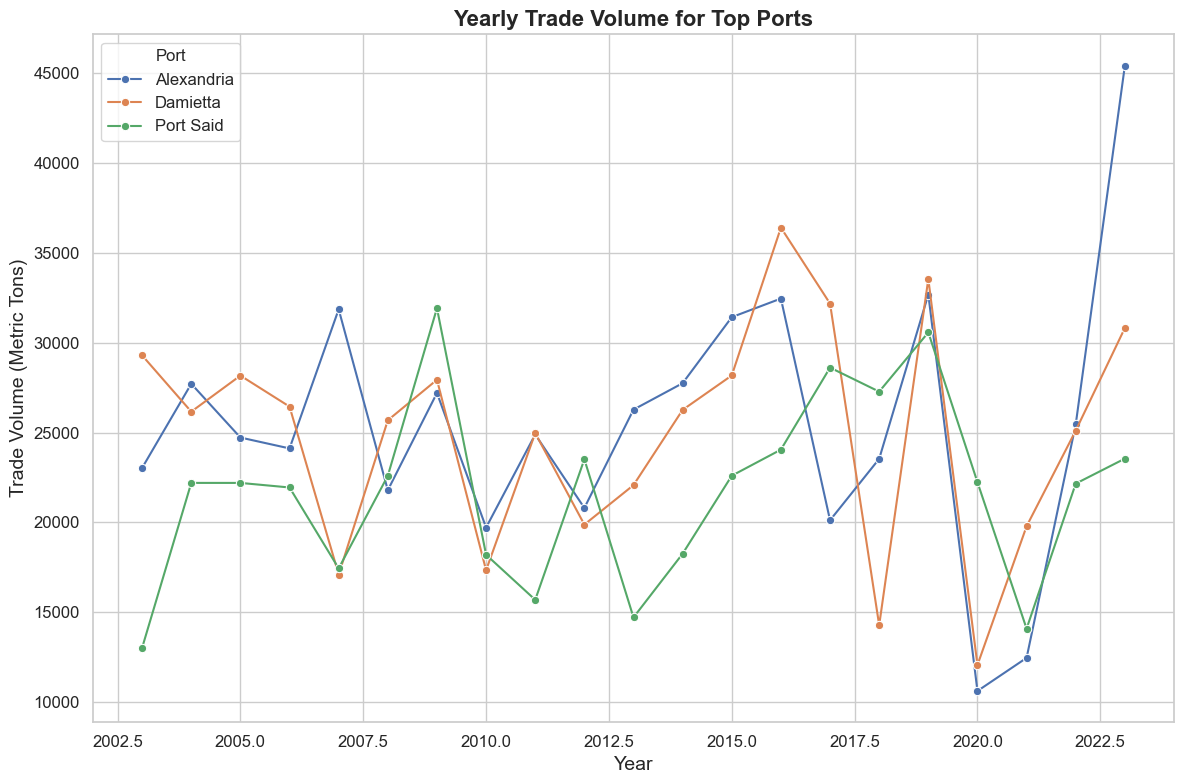

In [16]:
# Yearly Trade Volume for Top Ports
top_ports = trade_with_ports["Port"].value_counts().index[:3]  # Updated column name
top_port_data = trade_with_ports[trade_with_ports["Port"].isin(top_ports)]  # Filter for top ports

# Grouping and aggregating trade volume by year and port
grouped_data = top_port_data.groupby(["Trade Year", "Port"])["Trade Volume (Metric Tons)"].sum().reset_index()

plt.figure(figsize=(12, 8))

# Line plot for yearly trade volume
sns.lineplot(
    data=grouped_data,
    x="Trade Year",
    y="Trade Volume (Metric Tons)",
    hue="Port",
    marker="o"
)
plt.title("Yearly Trade Volume for Top Ports", fontsize=16, weight="bold")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Trade Volume (Metric Tons)", fontsize=14)
plt.legend(title="Port", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


## **Feasibility Analysis**

### **1. Data Preprocessing**

In [17]:
# Step 1: Prepare the data for Prophet
trade_trend = trade_volume_df.groupby('Trade Year')['Trade Volume (Metric Tons)'].sum().reset_index()
trade_trend.rename(columns={'Trade Year': 'ds', 'Trade Volume (Metric Tons)': 'y'}, inplace=True)
trade_trend['ds'] = pd.to_datetime(trade_trend['ds'], format='%Y')


### **2. Initialize and Fit the Prophet Model**

In [18]:
# Step 2: Initialize and fit the Prophet model
trade_model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
trade_model.fit(trade_trend)

# Create future dataframe for years 2025–2030
future_years = trade_model.make_future_dataframe(periods=6, freq='Y')


06:11:06 - cmdstanpy - INFO - Chain [1] start processing
06:11:06 - cmdstanpy - INFO - Chain [1] done processing


### **3. Predict Trade Volumes for 2025–2030**

In [19]:
# Step 3: Predict trade volumes for 2025–2030
trade_forecast = trade_model.predict(future_years)
future_trade_volumes = trade_forecast[['ds', 'yhat']].copy()
future_trade_volumes.rename(columns={'ds': 'Year', 'yhat': 'Predicted Trade Volume (Metric Tons)'}, inplace=True)
future_trade_volumes['Year'] = future_trade_volumes['Year'].dt.year
future_trade_volumes = future_trade_volumes[future_trade_volumes['Year'].between(2025, 2030)]  # Ensure 2025–2030


### **4. Evaluate Profits at Varying Shipping Rates**

In [20]:
# Step 4: Evaluate profits at varying shipping rates for 2025–2030
rates = np.arange(40, 61, 5)  # Shipping rates from $40 to $60 per ton
profit_results = []

for rate in rates:
    # Calculate revenue and profits for each rate
    future_trade_volumes[f'Revenue at ${rate}/ton'] = (
        future_trade_volumes['Predicted Trade Volume (Metric Tons)'] * rate
    )
    future_trade_volumes[f'Profit at ${rate}/ton'] = (
        future_trade_volumes[f'Revenue at ${rate}/ton'] -
        future_trade_volumes['Predicted Trade Volume (Metric Tons)'] * 35  # Operational cost at $35/ton
    )
    total_profit = future_trade_volumes[f'Profit at ${rate}/ton'].sum()
    profit_results.append({'Rate (USD per Ton)': rate, 'Total Profit (Million USD)': total_profit / 1e6})  # Convert to millions

# Create a DataFrame for total profits at different rates
profit_df = pd.DataFrame(profit_results)

# Convert all revenue and profit columns to millions in `future_trade_volumes`
for col in future_trade_volumes.columns:
    if 'Revenue' in col or 'Profit' in col:
        future_trade_volumes[col] = future_trade_volumes[col] / 1e6  # Convert to millions


### **5. Visualize Trade Volume Predictions**

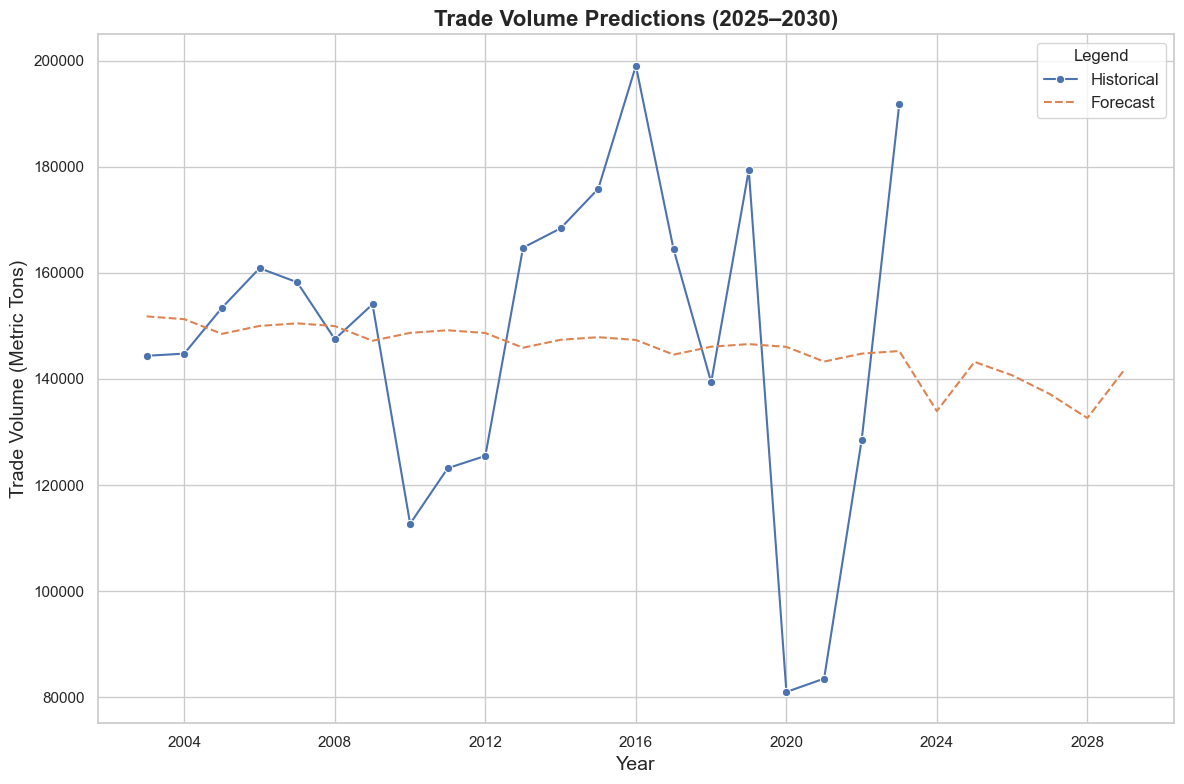

In [21]:
# Step 5: Visualize trade volume predictions
plt.figure(figsize=(12, 8))
sns.lineplot(data=trade_trend, x='ds', y='y', label='Historical', marker='o')
sns.lineplot(data=trade_forecast, x='ds', y='yhat', label='Forecast', linestyle='--')
plt.title("Trade Volume Predictions (2025–2030)", fontsize=16, weight="bold")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Trade Volume (Metric Tons)", fontsize=14)
plt.legend(title="Legend", fontsize=12)
plt.tight_layout()
plt.show()


### **6. Visualize Profits at Varying Rates**

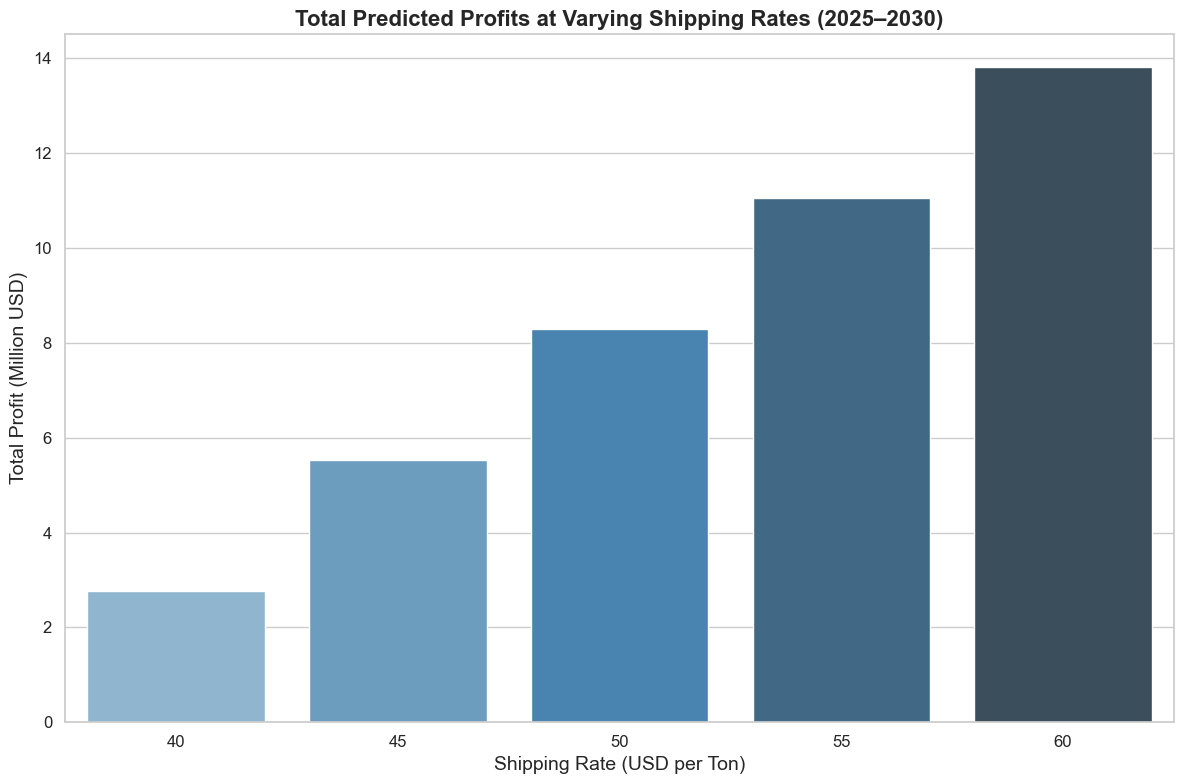

In [22]:
# Step 7: Visualize profits at varying rates
plt.figure(figsize=(12, 8))
sns.barplot(data=profit_df, x="Rate (USD per Ton)", y="Total Profit (Million USD)", palette="Blues_d")
plt.title("Total Predicted Profits at Varying Shipping Rates (2025–2030)", fontsize=16, weight="bold")
plt.xlabel("Shipping Rate (USD per Ton)", fontsize=14)
plt.ylabel("Total Profit (Million USD)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


### **7. Display Predictions**

In [23]:
# Display results for the executive report
pd.options.display.float_format = '{:,.2f}'.format  # Avoid scientific notation

# Step 7: Display trade volume predictions
print("\nTrade Volume Predictions for 2025–2030:")
display(future_trade_volumes)



Trade Volume Predictions for 2025–2030:


,Year,Predicted Trade Volume (Metric Tons),Revenue at $40/ton,Profit at $40/ton,Revenue at $45/ton,Profit at $45/ton,Revenue at $50/ton,Profit at $50/ton,Revenue at $55/ton,Profit at $55/ton,Revenue at $60/ton,Profit at $60/ton
23,2025,"140,692.09",5.63,0.70,6.33,1.41,7.03,2.11,7.74,2.81,8.44,3.52
24,2026,"137,161.54",5.49,0.69,6.17,1.37,6.86,2.06,7.54,2.74,8.23,3.43
25,2027,"132,636.13",5.31,0.66,5.97,1.33,6.63,1.99,7.29,2.65,7.96,3.32
26,2028,"141,916.48",5.68,0.71,6.39,1.42,7.10,2.13,7.81,2.84,8.51,3.55


In [24]:
# Display profit analysis at varying shipping rates
print("\nProfit Analysis at Varying Shipping Rates:")
display(profit_df)



Profit Analysis at Varying Shipping Rates:


,Rate (USD per Ton),Total Profit (Million USD)
0,40,2.76
1,45,5.52
2,50,8.29
3,55,11.05
4,60,13.81


### **8. Saving Predictions Data**

In [25]:
# Step 8: Save results to CSV for executive reporting
#future_trade_volumes.to_csv('./data/prediction/future_trade_and_profit_predictions.csv', index=False)
#profit_df.to_csv('./data/prediction/profit_analysis_at_varying_rates.csv', index=False)
